## 0.0 IMPORTS

##### Começamos o projeto com uma pratica simples e organizada que é importar as bibliotecas que iremos trabalhar ao longo de todo esse desafio. Sempre que precisarmos importar uma biblioteca ou uma classe de alguma biblioteca, utilizaremos essa seção.

In [15]:

import pandas as pd
import numpy as np
import seaborn as sns
import seaborn as sns; sns.set();
import matplotlib.pyplot as plt
import plotly.express as px
from scipy.stats import kurtosis, skew, norm
import math
import statistics
from scipy.stats import chi2
import pickle
# Biblioteca para fazer a PADRONIZAÇÃO
from sklearn.preprocessing import StandardScaler
# Biblioteca para fazer a NORMALIZAÇÃO
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.feature_selection import SelectKBest
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split

# Models ML
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier

# split data
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

# Metrics ML
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score, KFold

pd.set_option('float_format', '{:.2f}'.format)

## 0.1 - HELPER FUNCTION (FUNÇÕES AUXILIARES)

##### Aqui utilizaremos Funções que iram nos auxiliar em todo o projeto. Essas funções nos auxiliará diversas vezes, quando precisarmos sempre usar ações repetidamente.

In [2]:
"""Essa função, nos ajuda a rodar um describe executando as medidas Estatisticas como: média, mediana e desvio padrão. 

Também nos auxilia a entender as kurtosis e assimetria das nossas variaveis numéricas"""


def show_descriptive_statistical(df):
    # Central Tendency - mean, median
    ct1 = pd.DataFrame(df.apply(np.mean)).T
    ct2 = pd.DataFrame(df.apply(np.median)).T

    # Dispersion - std, min, max, range, skew, kurtosis
    d1 = pd.DataFrame(df.apply(np.std)).T
    d2 = pd.DataFrame(df.apply(min)).T
    d3 = pd.DataFrame(df.apply(max)).T
    d4 = pd.DataFrame(df.apply(lambda x: x.max() - x.min())).T
    d5 = pd.DataFrame(df.apply(lambda x: x.skew())).T
    d6 = pd.DataFrame(df.apply(lambda x: x.kurtosis())).T

    m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
    m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
    return m

def compute_metrics(yhat, y_validation, model_name):

    metric = pd.DataFrame(
        {'Model_name': model_name,
         'Balanced_accuracy': balanced_accuracy_score(y_validation, yhat),
         'Precision': precision_score(y_validation, yhat),
         'Recall': recall_score(y_validation, yhat),
         'F1-score': f1_score(y_validation, yhat)
        }, index=[0])

    return metric

def plot_metric(y_true, yhat, model_name):

    matrix = confusion_matrix(y_true, yhat)

    # show metric
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    sns.heatmap(matrix, annot=True, cmap='Greens')
    plt.title(f'Confusion Matrix - {model_name}')

    # figure with real data
    plt.subplot(1, 3, 2)
    sns.barplot(x=y_true.value_counts().index, y=y_true.value_counts().values, palette=None)
    plt.title('Fraud - Real')
    plt.xlabel('Fraud')
    sns.despine(right=True)

    # figure with prediction
    plt.subplot(1, 3, 3)
    pred = pd.Series(yhat).value_counts()
    sns.barplot(x=pred.index, y=pred.values, palette=None)
    plt.title('Fraud - Prediction')
    plt.xlabel('Prediction')
    sns.despine(right=True);

## 0.2 - PATH DEFINITION

In [3]:
HOME_PATH = '/home/valmir/Documentos/deteccao_fraude/'
RAW_DATA_PATH = 'data/raw/'
INTERIM_DATA_PATH = 'data/intermediario/'
FIGURE_PATH = 'reports/figures/'



## 0.3 - LOAD DATA

In [7]:
base_fraude_raw = pd.read_csv(HOME_PATH+RAW_DATA_PATH+'fraud_detection_dataset.csv')



## 1.0 - DATA DESCRIPITION

In [5]:
#base_fraude_raw1 = base_fraude_raw.copy()
#base_fraude_raw1.to_csv(HOME_PATH+INTERIM_DATA_PATH+'base_fraude_raw1.csv')
base_fraude_raw1 = pd.read_csv(HOME_PATH+INTERIM_DATA_PATH+'base_fraude_raw1.csv')


## 1.1 - DATA FIELD'S

Os dados contidos nesta base de dados são simulados e compreendem 30 dias. Estas transações podem ser de diferentes tipo e foram executadas via mobile devices. As features contidas nesta base de dados são:

 * `step` - Passo: representa o total de horas transcorrido desde o início da simulação. Esta feature vai variar entre 1 e 744(31
  dias);

 * `type`: Tipo: tipo de transação(depósito, saque, débito, pagamento e transferencia);

 * `amount`: Quantia: total que foi transacionado;

 * `nameOring`: ClienteOrigem: cliente que iniciou atransação;

 * `oldbalanceOrg`: SaldoInicialOrigem: saldo da conta de origem antes da transação;

 * `newbalanceOrig`: SaldoFinalOrigem: saldo da conta de origem depois da transação;

 * `nameDest`: ClienteDestino: cliente de destino da transação;

 * `oldbalandeDestino`: SaldoInicialDestino: saldo da conta destino antes da transação;

 * _`newbalanceDest`_: SaldoFinalDestino: saldo da conta destino depois da transação;

 * `isFraud`: Fraude: flag que define se a transação é fraudolenta ou não. Nesta simulação de fraude é a assumir se 'a conta do usuario foi   esvaziada e transferindo o dinherio para outra conta e depois sacado
 
 * `IssFlaggedFraud`: SinalizadaFraude: automaticamente categorizada como fraude pelo banco por fraude por tentar trasnferir mais de 200 mil em uma única conta


## 1.2 - RENAME COLUMNS

In [8]:
base_fraude_raw1.rename(columns={'step':'Tempo', 'type':'Tipo', 'amount': 'Quantia',
                                'nameOrig':'ClienteOrigem', 'oldbalanceOrg': 'SaldoInicalOrig',
                                'newbalanceOrig':'SaldoFinalOrig', 'nameDest':'ClienteDest',
                                'oldbalanceDest':'SaldoInicialDest', 'newbalanceDest':'SaldoFinalDest',
                                'isFraud':'Fraude', 'isFlaggedFraud':'SinalizadaFraude'}, inplace=True)


## 1.3 - DATA DIMENSIONS

In [1]:
num_linhas, num_colunas = base_fraude_raw1.shape

print('Numero de linhas', num_linhas)
print('Numero de colunas', num_colunas)

NameError: name 'base_fraude_raw1' is not defined

## 1.4 - DATA TYPES

In [9]:
#base_fraude_categoria = base_fraude_raw1[['Tipo','ClienteDest', 'ClienteOrigem']].astype('category')
base_fraude_raw1.dtypes

Unnamed: 0            int64
Tempo                 int64
Tipo                 object
Quantia             float64
ClienteOrigem        object
SaldoInicalOrig     float64
SaldoFinalOrig      float64
ClienteDest          object
SaldoInicialDest    float64
SaldoFinalDest      float64
Fraude                int64
SinalizadaFraude      int64
dtype: object

## 1.5 CHANGE TYPE

#### Não houve nenhuma mudança nos tipos de variaveis nessa etapa, pois todas as features se encontravam com seus tipos bem definidos

## 1.6 - CHECK N.A.

### Não foi encontrado nenhum valor nulo nesse Dataset

In [10]:
base_fraude_raw1.isnull().sum()

Unnamed: 0          0
Tempo               0
Tipo                0
Quantia             0
ClienteOrigem       0
SaldoInicalOrig     0
SaldoFinalOrig      0
ClienteDest         0
SaldoInicialDest    0
SaldoFinalDest      0
Fraude              0
SinalizadaFraude    0
dtype: int64

In [10]:
base_fraude_raw1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 12 columns):
 #   Column            Dtype  
---  ------            -----  
 0   Unnamed: 0        int64  
 1   Passos            int64  
 2   Tipo              object 
 3   Quantia           float64
 4   ClienteOrigem     object 
 5   SaldoInicalOrig   float64
 6   SaldoFinalOrig    float64
 7   ClienteDest       object 
 8   SaldoInicialDest  float64
 9   SaldoFinalDest    float64
 10  Fraude            int64  
 11  SinalizadaFraude  int64  
dtypes: float64(5), int64(4), object(3)
memory usage: 582.5+ MB


## 1.7 - FILL OUT N.A.

### Não havendo nenhum valor faltante nesse Dataset, não foi nescessario nenhum metodo de preenchimento ou exclusão dos mesmos

## 1.8 DISCRIPTIVE STATISTICAL

In [11]:
num_attributes = base_fraude_raw1.select_dtypes(include=['int64', 'float64'])
cat_attributes = base_fraude_raw1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])



Medidas de tendencia central - 
 - Media
 - Mediana
 

Medidas de Dispersão

- Skewness
- Kurtosis
- Desvio Padrão
- Range (alcance)
- Min
- Max

### 1.8.1 - NUMERIC ESTATISTIC

In [12]:
m = show_descriptive_statistical(num_attributes)
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,Unnamed: 0,0.000,6362619.000,6362619.000,3181309.500,3181309.500,1836730.185,0.000,-1.200
1,Tempo,1.000,743.000,742.000,243.397,239.000,142.332,0.375,0.329
2,Quantia,0.000,92445516.640,92445516.640,179861.904,74871.940,603858.184,30.994,1797.957
3,SaldoInicalOrig,0.000,59585040.370,59585040.370,833883.104,14208.000,2888242.446,5.249,32.965
4,SaldoFinalOrig,0.000,49585040.370,49585040.370,855113.669,0.000,2924048.273,5.177,32.067
5,SaldoInicialDest,0.000,356015889.350,356015889.350,1100701.667,132705.665,3399179.846,19.922,948.674
6,SaldoFinalDest,0.000,356179278.920,356179278.920,1224996.398,214661.440,3674128.653,19.352,862.157
7,Fraude,0.000,1.000,1.000,0.001,0.000,0.036,27.780,769.703
8,SinalizadaFraude,0.000,1.000,1.000,0.000,0.000,0.002,630.604,397659.062


In [13]:
base_fraude_raw1.tail()

,Unnamed: 0,Passos,Tipo,Quantia,ClienteOrigem,SaldoInicalOrig,SaldoFinalOrig,ClienteDest,SaldoInicialDest,SaldoFinalDest,Fraude,SinalizadaFraude
6362615,6362615,743,CASH_OUT,339682.130,C786484425,339682.130,0.000,C776919290,0.000,339682.130,1,0
6362616,6362616,743,TRANSFER,6311409.280,C1529008245,6311409.280,0.000,C1881841831,0.000,0.000,1,0
6362617,6362617,743,CASH_OUT,6311409.280,C1162922333,6311409.280,0.000,C1365125890,68488.840,6379898.110,1,0
6362618,6362618,743,TRANSFER,850002.520,C1685995037,850002.520,0.000,C2080388513,0.000,0.000,1,0
6362619,6362619,743,CASH_OUT,850002.520,C1280323807,850002.520,0.000,C873221189,6510099.110,7360101.630,1,0


### 1.8.2 - CATEGORICAL ATRIBUTES



In [13]:
cat_attributes.apply(lambda x: x.unique().shape[0])

Tipo                   5
ClienteOrigem    6353307
ClienteDest      2722362
dtype: int64

## 2.0 - FEATURE ENGINEERING- PARTE I

In [11]:
#base_fraude_raw2 = base_fraude_raw1.copy()
#base_fraude_raw2.to_csv(HOME_PATH+INTERIM_DATA_PATH+'base_fraude_raw2.csv')
base_fraude_raw2 = pd.read_csv(HOME_PATH+INTERIM_DATA_PATH+'base_fraude_raw2.csv')

## 2.1 - MAPA MENTAL DE HIPOTESE

![MapaMental de Hipotese]
(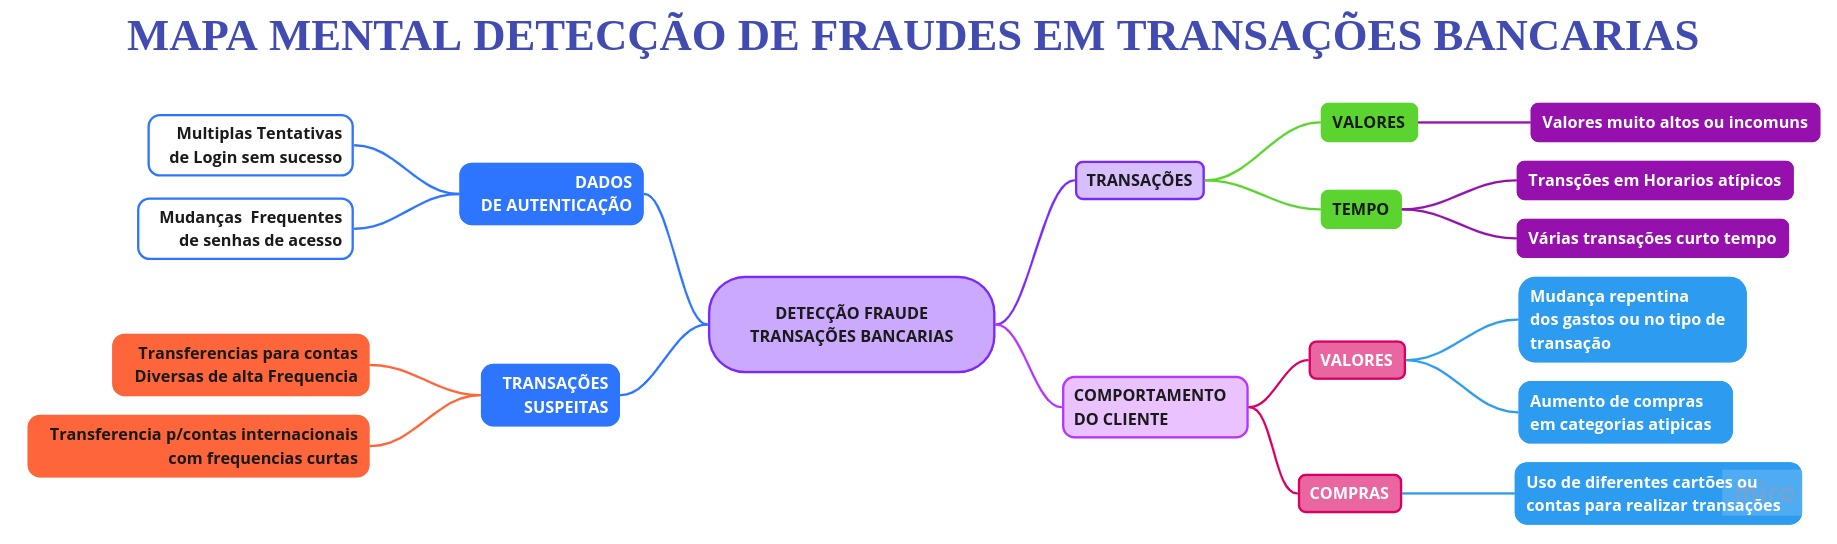)


## 2.2 - CRIAÇÃO DAS HIPOTESE

### TRANSAÇÕES 
 * QUANDO OS VALORES DAS TRANSAÇÕES FOREM MUITO ALTOS OU INCOMUNS EM RELAÇÃO AOS PADRÕES COMUNS DO CLIENTE, SERAM CLASSIFICADOS COMO FRAUDES;

 * QUANDO AS TRANSAÇÕES FOREM REALIZADAS EM HORÁRIOS ATÍPICOS AOS PADRÕES COMUNS REALIZADAS PELO CLIENTE, SERAM CLASSIFICADOS COMO FRAUDES;

 * QUANDO AS TRANSAÇÕES FOREM REALIZADAS EM MOMENTOS DE TEMPO MUITO CURTOS, SERAM CLASSIFICADOS COMO FRAUDES; 

 ### COMPORTAMENTO DO CLIENTE
 * QUANDO HOUVER MUDANÇAS REPENTINAS DOS VALORES DOS GASTOS E/OU DA FORMA DE TRANSAÇÃO TÍPICA DO CLIENTE, SERAM CLASSIFICADOS COMO FRAUDES;

 * QUANDO AS TRANSAÇÕES MUDAREM REPENTINAMENTE DO TIPO DA CATEGORIA QUE O CLIENTE EVENTUALMENTE REALIZA, SERAM CLASSIFICADOS COMO FRAUDES;

 * QUANDO HOUVER A TROCA DESORDENADA DO CARTÃO QUE O CLIENTE UTILIZA EVENTUALMENTE EM SUAS TRANSAÇÕES, SERAM CLASSIFICADOS COMO FRAUDES;

 ### DADOS DE AUTENTICAÇÃO
 * QUANDO HOUVER MULTIPLAS TENTATIVAS ERRADAS, SOLICITAÇÃO DE NOVA SENHA ANTES DO CLIENTE CONSEGUIR LOGAR, SERAM CLASSIFICADOS COMO FRAUDES;
 
 ### TRANSAÇÕES SUSPEITAS
 * QUANDO HOUVER TRANSFERENCIAS PARA CONTAS DIVERSAS DAS HABITUAIS REALIZADAS PELO CLIENTE, SERAM CLASSIFICADOS COMO FRAUDES;
 
 * QUANDO HOUVER TRANSFERENCIAS PARA CONTAS INTERNACIONAIS COM FREQUENCIAS DE CURTO ESPAÇO DE TEMPO, SERAM CLASSIFICADOS COMO FRAUDES;


## 2.3 - LISTA FINAL DE HIPOTESE

### TRANSAÇÕES 
 * QUANDO OS VALORES DAS TRANSAÇÕES FOREM MAIORES QUE 50% DO SALDO INICIAL, SERAM CLASSIFICADOS COMO FRAUDES;

 * QUANDO AS TRANSAÇÕES FOREM REALIZADAS EM MOMENTOS DE TEMPO MUITO CURTOS, SERAM CLASSIFICADOS COMO FRAUDES; 

 ### COMPORTAMENTO DO CLIENTE
 * OS CLIENTES QUE TIVEREM PODER AQUISITIVO ALTO, ONDE A MEDIA SALARIAL AMERICA CONSTADA É DE $ 3.800,00, SERAM CLASSIFICADOS COMO FRAUDES;

 ### TRANSAÇÕES SUSPEITAS
 * APÓS CLASSIFICADOS OS TIPOS CLIENTES DE ORIGEM E CLIENTES DE DESTINO DE C PARA CLIENTES COMUNS E M PARA ORGANIZAÇÕES, AS TRANSAÇÕES SUSPEITAS QUE CONSIDRERAM COMO FRAUDES SERÃO AS DE CLIENTES PARA CLIENTES;
 
 

## 2.4 - FEATURE ENGINEERING - PARTE 1

In [15]:
base_fraude_raw2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 13 columns):
 #   Column            Dtype  
---  ------            -----  
 0   Unnamed: 0.1      int64  
 1   Unnamed: 0        int64  
 2   Passos            int64  
 3   Tipo              object 
 4   Quantia           float64
 5   ClienteOrigem     object 
 6   SaldoInicalOrig   float64
 7   SaldoFinalOrig    float64
 8   ClienteDest       object 
 9   SaldoInicialDest  float64
 10  SaldoFinalDest    float64
 11  Fraude            int64  
 12  SinalizadaFraude  int64  
dtypes: float64(5), int64(5), object(3)
memory usage: 631.1+ MB


`TRANSAÇÕES FOREM MAIORES QUE 50% DO SALDO INICIAL? `

Criei uma Feature chamada "MAIOR_50%" para classificar como yes e no para transações acima de 50% do Saldo Original;

`PODER AQUISITIVO DOS CLIENTES? ` 

Criei uma Feature chamada "PODER_COMPRA" para classificar como ALTA, MÉDIO E BAIXA o poder aquisitivo dos clientes baseado na média salarial americana que seria de $3.800,00 sobre o saldo inicial dos clientes;

`CLASSIFICADOS OS TIPOS CLIENTES DE ORIGEM E CLIENTES DE DESTINO DE C PARA CLIENTES COMUNS E M PARA ORGANIZAÇÕES, AS TRANSAÇÕES SUSPEITAS QUE CONSIDRERAM COMO FRAUDES SERÃO AS DE CLIENTES PARA CLIENTES; ` 

Criei uma Feature chamada "TIPO_TRANSACAO" para classificar como C e M, onde C seriam clientes comuns e M seriam clientes organizacionais.

In [12]:
base_fraude_raw2['maior_50%'] = base_fraude_raw2[['Quantia', 'SaldoInicalOrig']].apply(
    lambda x: 'yes' if x['Quantia'] / 2 > x['SaldoInicalOrig'] else 'no', axis=1)


base_salarial = 3800
media_salarial = base_fraude_raw2['SaldoInicalOrig'].median()

base_fraude_raw2['poder_compra'] = base_fraude_raw2['SaldoInicalOrig'].apply(
    lambda x: 'baixa' if x <= base_salarial else 'medio'
                      if x > base_salarial and x <= media_salarial else 'alta')


base_fraude_raw2['tipo_transacao'] = base_fraude_raw2[['ClienteOrigem', 'ClienteDest']].apply(
    lambda x: 'C para C' if x['ClienteOrigem'][0] == 'C' and x['ClienteDest'][0] == 'C' else 'M para M'
                         if x['ClienteOrigem'][0] == 'M' and x['ClienteDest'][0] == 'M' else 'C para M'
                         if x['ClienteOrigem'][0] == 'C' and x['ClienteDest'][0] == 'M' else 'M para C'
                         if x['ClienteOrigem'][0] == 'M' and x['ClienteDest'][0] == 'C' else None, axis=1)

In [9]:
base_fraude_raw2.head()

,Unnamed: 0.1,Unnamed: 0,Passos,Tipo,Quantia,ClienteOrigem,SaldoInicalOrig,SaldoFinalOrig,ClienteDest,SaldoInicialDest,SaldoFinalDest,Fraude,SinalizadaFraude,maior_50%,poder_compra,tipo_transacao
0,0,0,1,PAYMENT,9839.640,C1231006815,170136.000,160296.360,M1979787155,0.000,0.000,0,0,no,alta,C para M
1,1,1,1,PAYMENT,1864.280,C1666544295,21249.000,19384.720,M2044282225,0.000,0.000,0,0,no,alta,C para M
2,2,2,1,TRANSFER,181.000,C1305486145,181.000,0.000,C553264065,0.000,0.000,1,0,no,baixa,C para C
3,3,3,1,CASH_OUT,181.000,C840083671,181.000,0.000,C38997010,21182.000,0.000,1,0,no,baixa,C para C
4,4,4,1,PAYMENT,11668.140,C2048537720,41554.000,29885.860,M1230701703,0.000,0.000,0,0,no,alta,C para M


## 3.0 - FILTRAGEM DE VARIAVEIS 

In [41]:
"""base_fraude_raw3 = base_fraude_raw2.copy()
base_fraude_raw3.to_csv(HOME_PATH+INTERIM_DATA_PATH+'base_fraude_raw3.csv')"""
base_fraude_raw3 = pd.read_csv(HOME_PATH+INTERIM_DATA_PATH+'base_fraude_raw3.csv')

## 3.1 - FILTRAGEM DE LINHAS 
Devido termos poucas colunas a quantidade de linhas farão toda a diferença, visto que não possuimos valores nulos e o valores `0` em algumas 

linhas são afirmações de `NÃO TRANSAÇÃO`, impactando assim, diretamente nos resultados finais.

In [42]:
"""ANALISAMOS QUE A FORMA DE PAGAMENTO QUE MAIS POSSUI FRAUDES SÃO CASH_OUT E TRANSFER.
SABENDO DISSO, REDUZIMOS O DATASET APENAS PARA AS TRANSAÇÕES DE CASH_OUT E TRANSFER
QUE SÃO CONSIDERADAS FRAUDES. COM ISSO, NÃO DESPREZAMOS AS TRANSAÇÕES QUE NÃO SÃO
FRAUDES."""

"""base_fraude_real = base_fraude_raw4[base_fraude_raw4['Fraude'] == 1]"""
tipos_fraude = ["CASH_OUT", "TRANSFER"]
base_fraude_real = base_fraude_raw3[base_fraude_raw3['Tipo'].isin(tipos_fraude)]
base_fraude_real.head()

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,Passos,Tipo,Quantia,ClienteOrigem,SaldoInicalOrig,SaldoFinalOrig,ClienteDest,SaldoInicialDest,SaldoFinalDest,Fraude,SinalizadaFraude,maior_50%,poder_compra,tipo_transacao
2,2,2,2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0,no,baixa,C para C
3,3,3,3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,0,no,baixa,C para C
15,15,15,15,1,CASH_OUT,229133.94,C905080434,15325.00,0.00,C476402209,5083.00,51513.44,0,0,yes,alta,C para C
19,19,19,19,1,TRANSFER,215310.30,C1670993182,705.00,0.00,C1100439041,22425.00,0.00,0,0,yes,baixa,C para C
24,24,24,24,1,TRANSFER,311685.89,C1984094095,10835.00,0.00,C932583850,6267.00,2719172.89,0,0,yes,medio,C para C


## 3.2 - FILTRAGEM DE COLUNAS - SELEÇÃO DAS COLUNAS

Devido termos poucas colunas a quantidade de linhas farão toda a diferença, visto que não possuimos valores nulos e o valores `0` em algumas 

linhas são afirmações de `NÃO TRANSAÇÃO`, impactando assim, diretamente nos resultados finais.

In [11]:
base_fraude_raw3.head()

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,Passos,Tipo,Quantia,ClienteOrigem,SaldoInicalOrig,SaldoFinalOrig,ClienteDest,SaldoInicialDest,SaldoFinalDest,Fraude,SinalizadaFraude,maior_50%,poder_compra,tipo_transacao
0,0,0,0,1,PAYMENT,9839.640,C1231006815,170136.000,160296.360,M1979787155,0.000,0.000,0,0,no,alta,C para M
1,1,1,1,1,PAYMENT,1864.280,C1666544295,21249.000,19384.720,M2044282225,0.000,0.000,0,0,no,alta,C para M
2,2,2,2,1,TRANSFER,181.000,C1305486145,181.000,0.000,C553264065,0.000,0.000,1,0,no,baixa,C para C
3,3,3,3,1,CASH_OUT,181.000,C840083671,181.000,0.000,C38997010,21182.000,0.000,1,0,no,baixa,C para C
4,4,4,4,1,PAYMENT,11668.140,C2048537720,41554.000,29885.860,M1230701703,0.000,0.000,0,0,no,alta,C para M


In [43]:
del base_fraude_real['Unnamed: 0']
del base_fraude_real['Unnamed: 0.1']
del base_fraude_real['Unnamed: 0.2']

## 4.0 - ANALISE E VISUALIZAÇÕES

In [44]:
base_fraude_raw4 = base_fraude_real.copy()
base_fraude_raw4.to_csv(HOME_PATH+INTERIM_DATA_PATH+'base_fraude_raw4.csv')
base_fraude_raw4 = pd.read_csv(HOME_PATH+INTERIM_DATA_PATH+'base_fraude_raw4.csv')

In [45]:
base_fraude_raw4.memory_usage().sum() / 1024**2

317.0482711791992

### 4.1 - Amostragem Estratificada Uniforme

In [46]:
n_samples = 8000

# Dividindo o conjunto de dados em estratos com base na variável 'isFraud'
estratos = base_fraude_raw4.groupby('Fraude')

In [47]:
# Selecionando um número igual de amostras de cada estrato
amostra_uniforme = pd.concat([estrato.sample(n=n_samples) for _, estrato in estratos])

# Agora, amostra_uniforme é uma amostra estratificada uniforme do conjunto de dados original
amostra_uniforme.shape

(16000, 15)

In [ ]:
del amostra_uniforme['Unnamed: 0']
amostra_uniforme.head(5)

#### 4.1.1 - SALVAR BASE DE AMOSTRAGEM COM PICKLE

In [ ]:
with open('amostra_uniforme.pkl', mode = 'wb') as f:
    pickle.dump(amostra_uniforme,f)

In [5]:
with open('/home/valmir/Documentos/deteccao_fraude/data/raw/amostra_uniforme.pkl', 'rb') as f:
    amostra_uniforme = pickle.load(f)

### 4.2 - Análise e Visualização Univariada

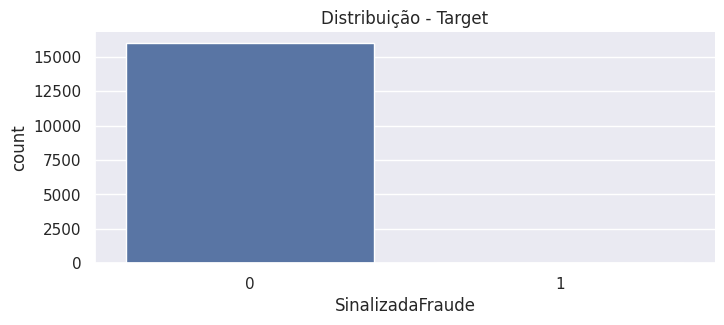

In [49]:
# Figure 
plt.figure(figsize=(8, 3))
sns.countplot(x='SinalizadaFraude', data=amostra_uniforme, palette=None)
sns.despine(right=True)
plt.title('Distribuição - Target');

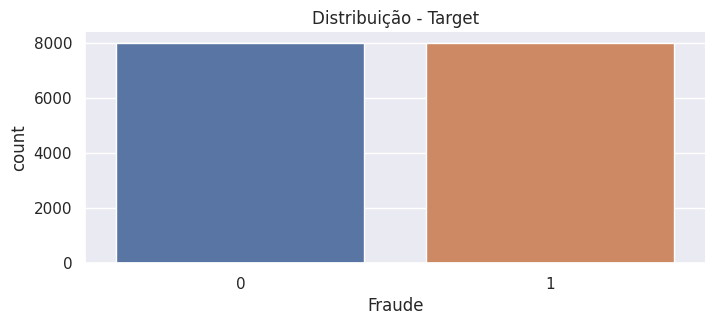

In [50]:
# Figure 
plt.figure(figsize=(8, 3))
sns.countplot(x='Fraude', data=amostra_uniforme, palette=None)
sns.despine(right=True)
plt.title('Distribuição - Target');

### 4.3 - Análise e Visualização Bivariada

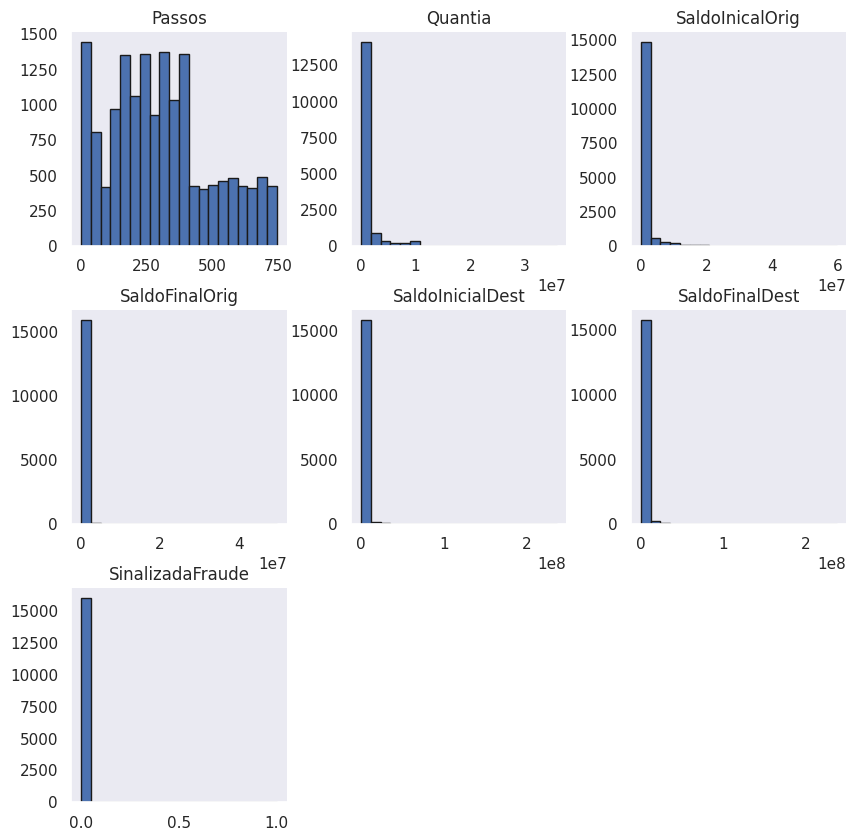

In [51]:
# Filter numerical atributes
num = amostra_uniforme.select_dtypes(include=['int64', 'float64']).drop(columns=['Fraude'])

# Figure
num.hist(grid=False, bins=20, ec='k', figsize=(10, 10))
sns.despine(right=True)
plt.title('Dsitribuição Variaveis Numéricas');

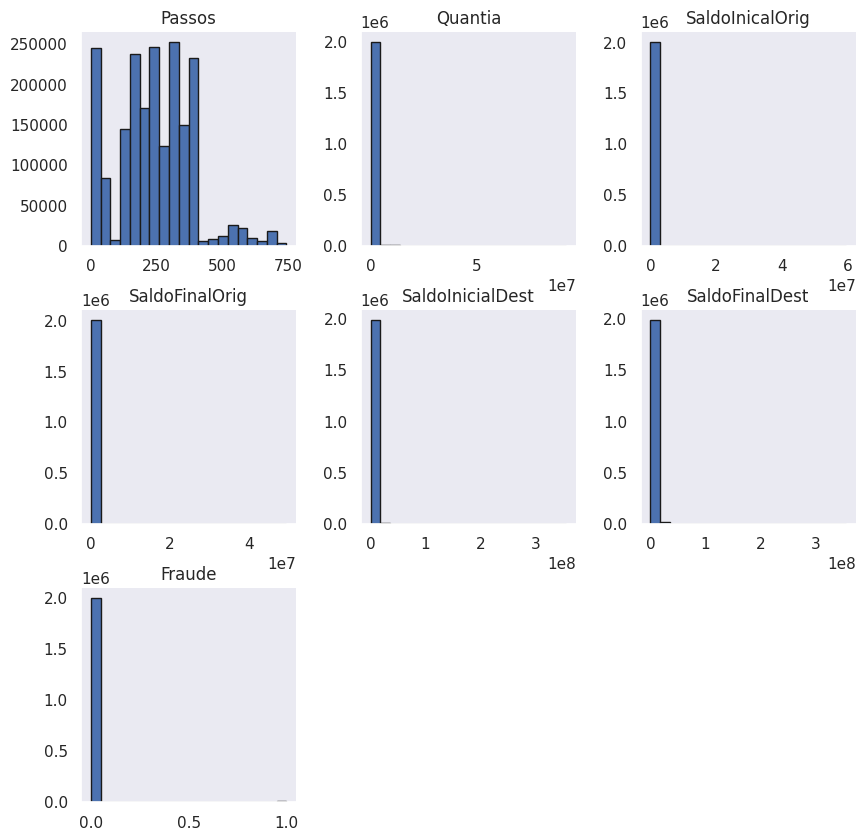

In [22]:
# Filter numerical atributes
num = X_train.select_dtypes(include=['int64', 'float64']).drop(columns=['SinalizadaFraude'])

# Figure
num.hist(grid=False, bins=20, ec='k', figsize=(10, 10))
sns.despine(right=True)
plt.title('Dsitribuição Variaveis Numéricas');

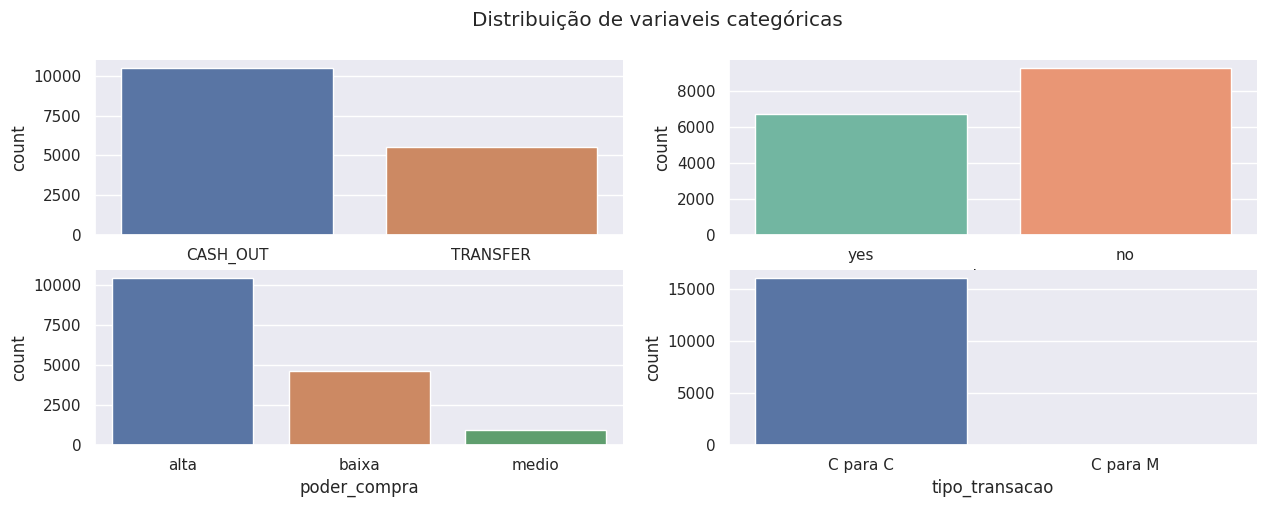

In [52]:
# Filter categorical atributes
cat = amostra_uniforme.select_dtypes(include=['object'])

# Figure 1
plt.figure(figsize=(15, 5))
plt.subplot(2, 2, 1)
sns.countplot(x='Tipo', data=cat, order=list(cat['Tipo'].value_counts().sort_values(ascending=False).index), palette= None)
plt.suptitle('Distribuição de variaveis categóricas')
sns.despine(right=True)
# Figure 2
plt.subplot(2, 2, 2)
sns.countplot(x='maior_50%', data=cat, order=['yes', 'no'], palette= "Set2")
sns.despine(right=True)

# Figure 3
plt.subplot(2, 2, 3)
sns.countplot(x='poder_compra', data=cat, palette=None)
sns.despine(right=True)

# Figure 4
plt.subplot(2, 2, 4)
sns.countplot(x='tipo_transacao', data=cat, order=['C para C', 'C para M'], palette=None)
sns.despine(right=True);

`Insight:` 
* Com a amostra balanceada da base, analisando as transações fraudulentas, percebemos que os tipos de transações são os únicos numeros de casos são CASH_OUT e TRANSFERENCIA.
* Com a amostra balanceada da base, analisando o saldo inicial, constatamos que a maioria das pessoas realizam as transações menores que 50% do valor delas em seus saldos iniciais.
* Com a amostra balanceada da base, analisando o poder de compra, pela media salarial de $ 3.800,00, é alto o poder aquisitivo.
* Com a amostra balanceada da base, conseguimos categorizar o tipo de transação entre clientes e empresas e a grande maioria das fraudes são realizadas de clientes para clientes.

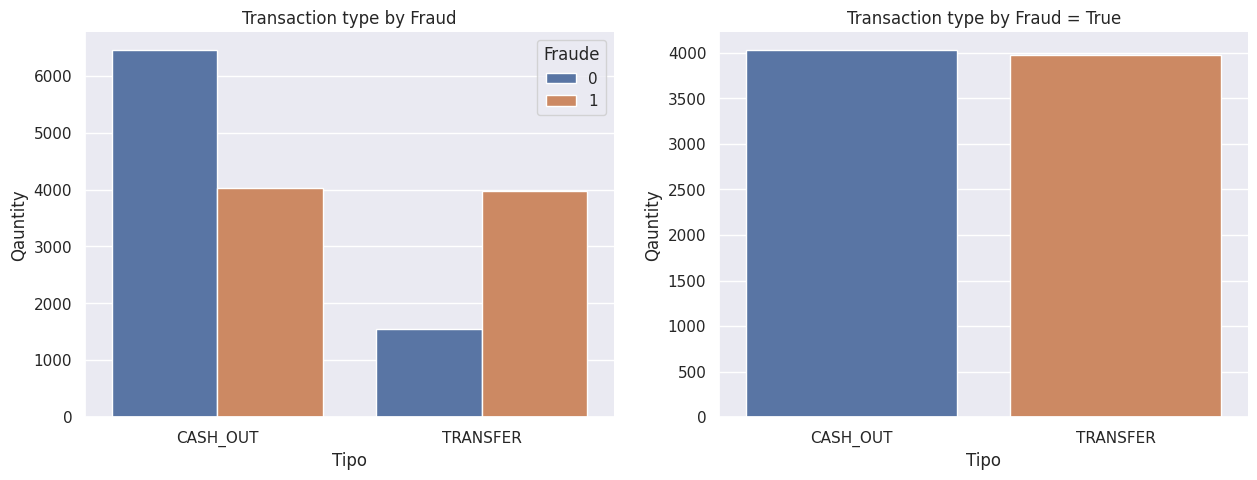

In [53]:
# figure 1
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.countplot(x='Tipo', data=amostra_uniforme, hue='Fraude', palette=None)
plt.ylabel('Qauntity')
plt.title('Transaction type by Fraud')
sns.despine(right=True)

# figure 2
plt.subplot(1, 2, 2)
filter_fraud = amostra_uniforme[amostra_uniforme['Fraude'] == 1]
sns.countplot(x='Tipo', data=filter_fraud, palette=None)
plt.ylabel('Qauntity')
plt.title('Transaction type by Fraud = True')
sns.despine(right=True);

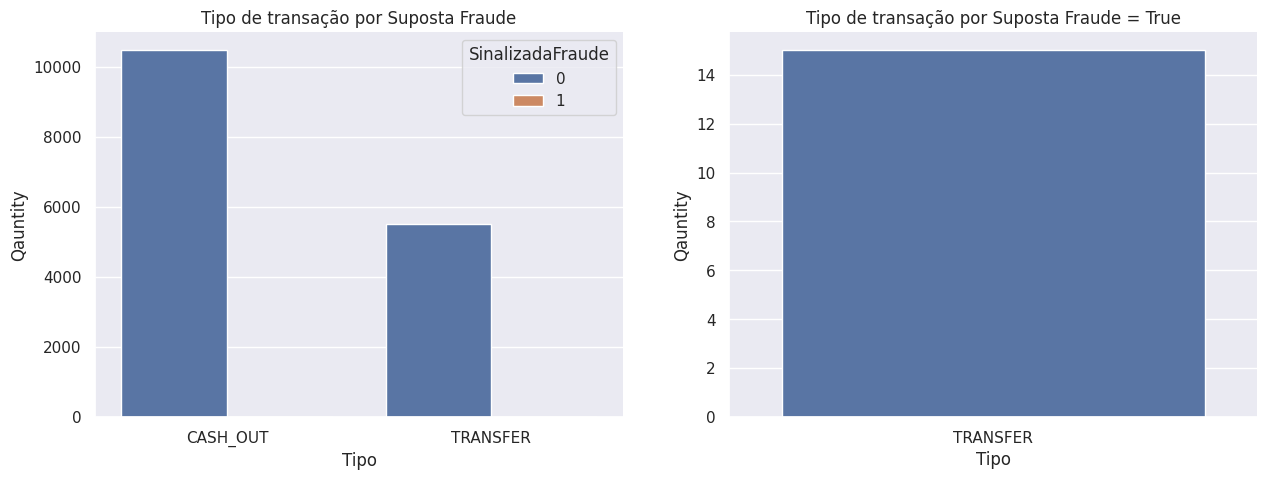

In [54]:
# figure 1
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.countplot(x='Tipo', data=amostra_uniforme, hue='SinalizadaFraude', palette=None)
plt.ylabel('Qauntity')
plt.title('Tipo de transação por Suposta Fraude')
sns.despine(right=True)

# figure 2
plt.subplot(1, 2, 2)
filter_fraud = amostra_uniforme[amostra_uniforme['SinalizadaFraude'] == 1]
sns.countplot(x='Tipo', data=filter_fraud, palette=None)
plt.ylabel('Qauntity')
plt.title('Tipo de transação por Suposta Fraude = True')
sns.despine(right=True);

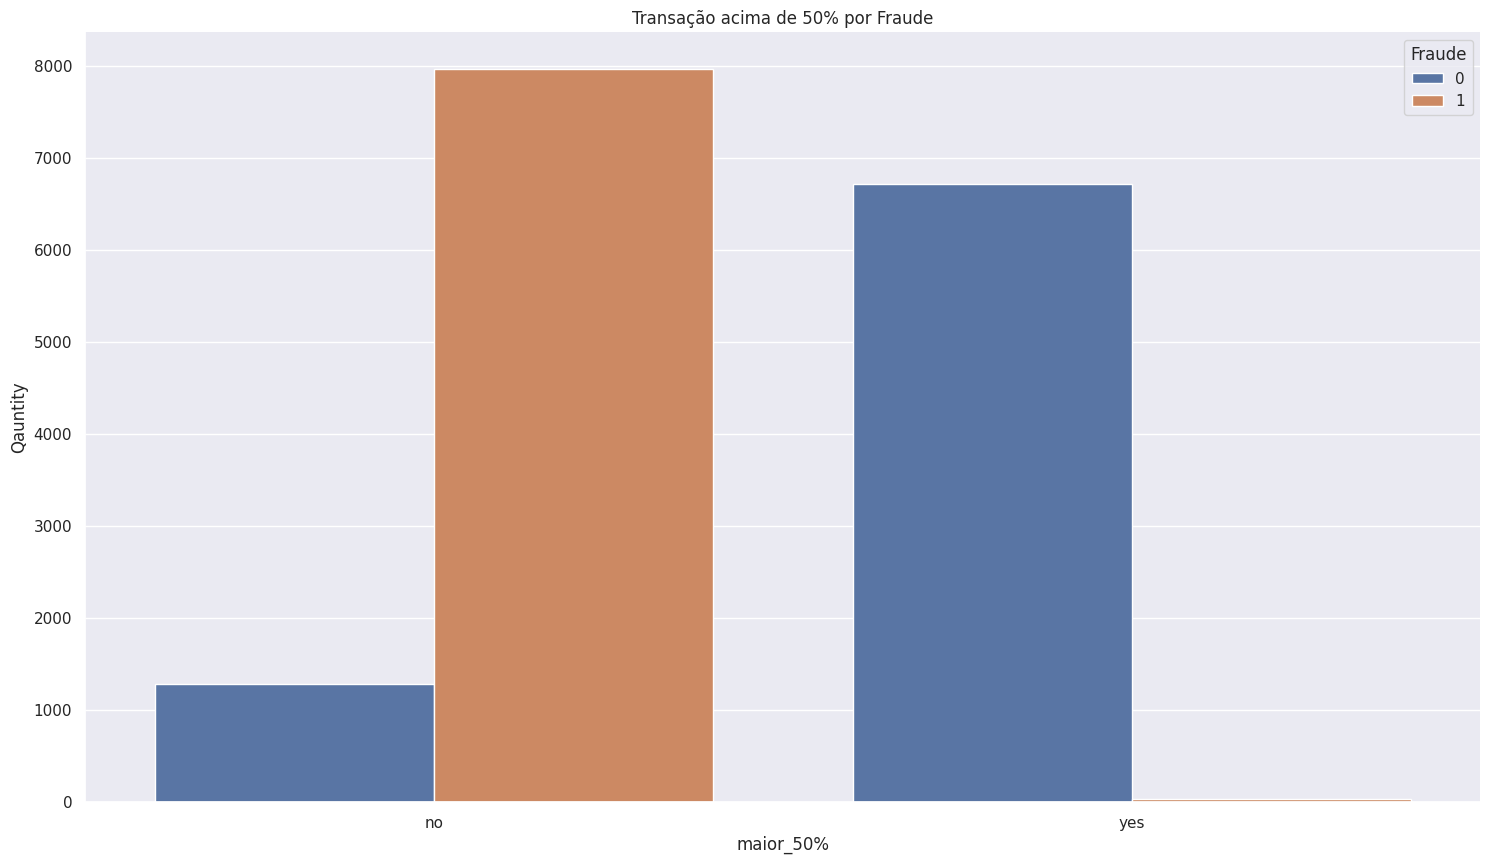

In [55]:
plt.figure(figsize=(18, 10))
sns.countplot(x='maior_50%', data=amostra_uniforme, hue='Fraude', palette=None)
plt.ylabel('Qauntity')
plt.title('Transação acima de 50% por Fraude')
sns.despine(right=True);


* Verifiamos que as transações maiores que 50% do Saldo Inicial NÃO são fraudes

In [ ]:
median_group = amostra_uniforme['Quantia'].groupby(amostra_uniforme['Fraude']).median().reset_index()

# Figure 1
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.barplot(x='Fraude', y='Quantia', data=median_group, palette=None)
plt.title('Valor Mediano de Transação por Fraude')
sns.despine(right=True)

# Figure 2
plt.subplot(1, 2, 2)
sns.countplot(x='tipo_transacao', data=X_train, hue='Fraude', palette=None)
plt.ylabel('Qauntity')
plt.title('Valor categórico de Transação por Fraude')
sns.despine(right=True);

* Percebemos que as fraudes, possui em seu maios valor acima $400.000,00(quatrocentos mil) e a maioria de Transações normais são de Cliente para Cliente

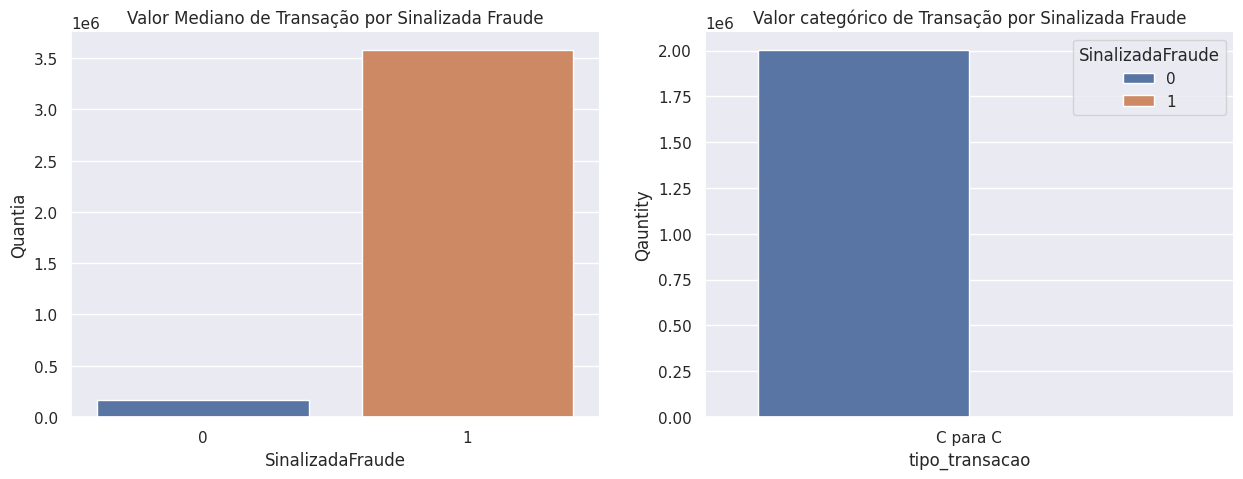

In [30]:
median_group = amostra_uniforme['Quantia'].groupby(amostra_uniforme['SinalizadaFraude']).median().reset_index()

# Figure 1
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.barplot(x='SinalizadaFraude', y='Quantia', data=median_group, palette=None)
plt.title('Valor Mediano de Transação por Sinalizada Fraude')
sns.despine(right=True)

# Figure 2
plt.subplot(1, 2, 2)
sns.bo(x='tipo_transacao', data=X_train, hue='SinalizadaFraude', palette=None)
plt.ylabel('Qauntity')
plt.title('Valor categórico de Transação por Sinalizada Fraude')
sns.despine(right=True);

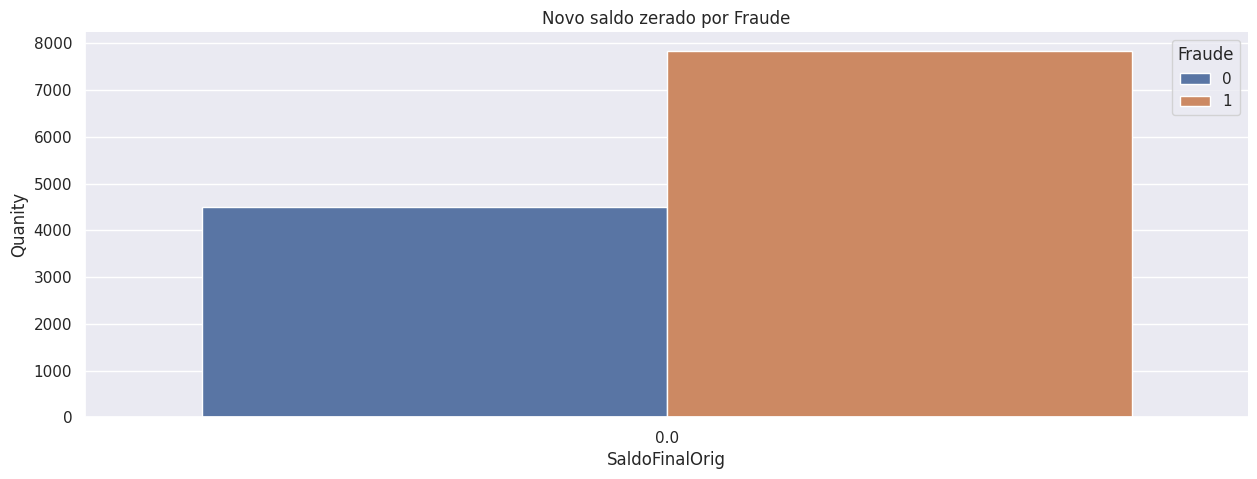

In [31]:
novovalor_orig_zero = amostra_uniforme[amostra_uniforme['SaldoFinalOrig'] == 0]

plt.figure(figsize=(15, 5))
sns.countplot(x='SaldoFinalOrig', data=novovalor_orig_zero, hue='Fraude', palette=None)
plt.ylabel('Quanity')
plt.title('Novo saldo zerado por Fraude')
sns.despine(right=True);

* As Transações fraudulentas na sua grande maioria, os saldos originais finais são zerados

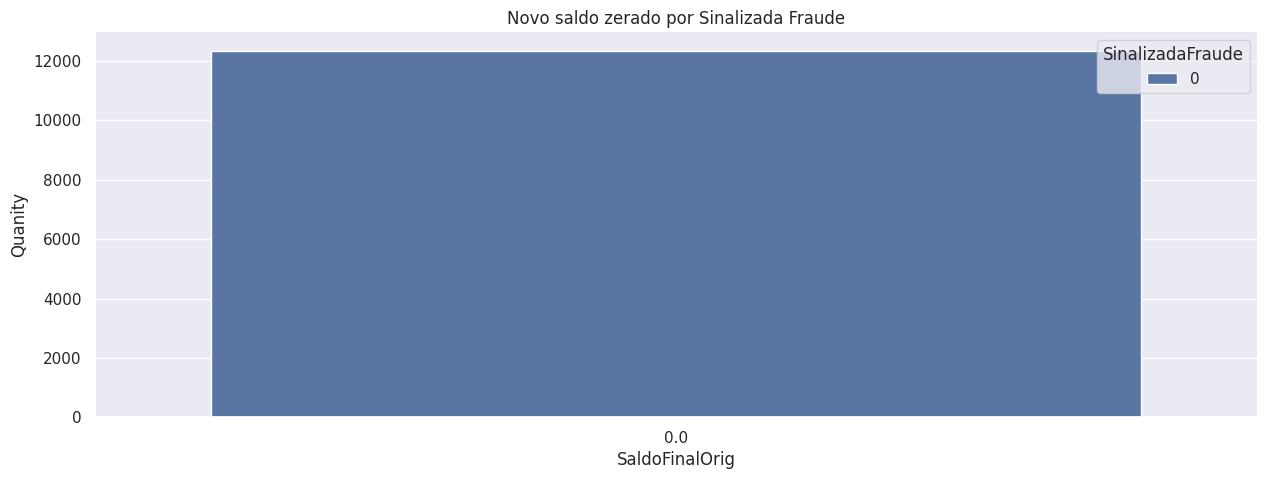

In [32]:
novovalor_orig_zero = amostra_uniforme[amostra_uniforme['SaldoFinalOrig'] == 0]

plt.figure(figsize=(15, 5))
sns.countplot(x='SaldoFinalOrig', data=novovalor_orig_zero, hue='SinalizadaFraude', palette=None)
plt.ylabel('Quanity')
plt.title('Novo saldo zerado por Sinalizada Fraude')
sns.despine(right=True);

* Interpretamos acima, que o saldo final zerado, como se tirasse tudo depois da fraude, teoria essa apresentada pela a empresa responsavel pelos dados que os classificam Fraude ou Não, não caracteriza Fraude

* Aqui confirmamos que as transações fraudulentas são em sua grande maioria sofridas por clientes de poder aquisitivo ALTO

In [19]:
fig = px.scatter(amostra_uniforme, x = "Quantia", y = "Fraude", size = "SaldoInicialDest", color = 'poder_compra', 
               hover_name = "poder_compra", log_x = True, size_max = 100, width = 900)
fig.update_layout(title = 'Poder aquisitivo por Fraude')
fig.update_xaxes(title = 'FRAUDE')
fig.update_yaxes(title = 'Expectativa de vida')
fig.show()

* Percebemos que as maiores quantidades de Fraudes, são com clientes de poder aquisitivo Alto, mediando pelo valor de salario de $3.800,00(tre mil e oitocentos)

### 4.4 - Análise e Visualização Multivariada

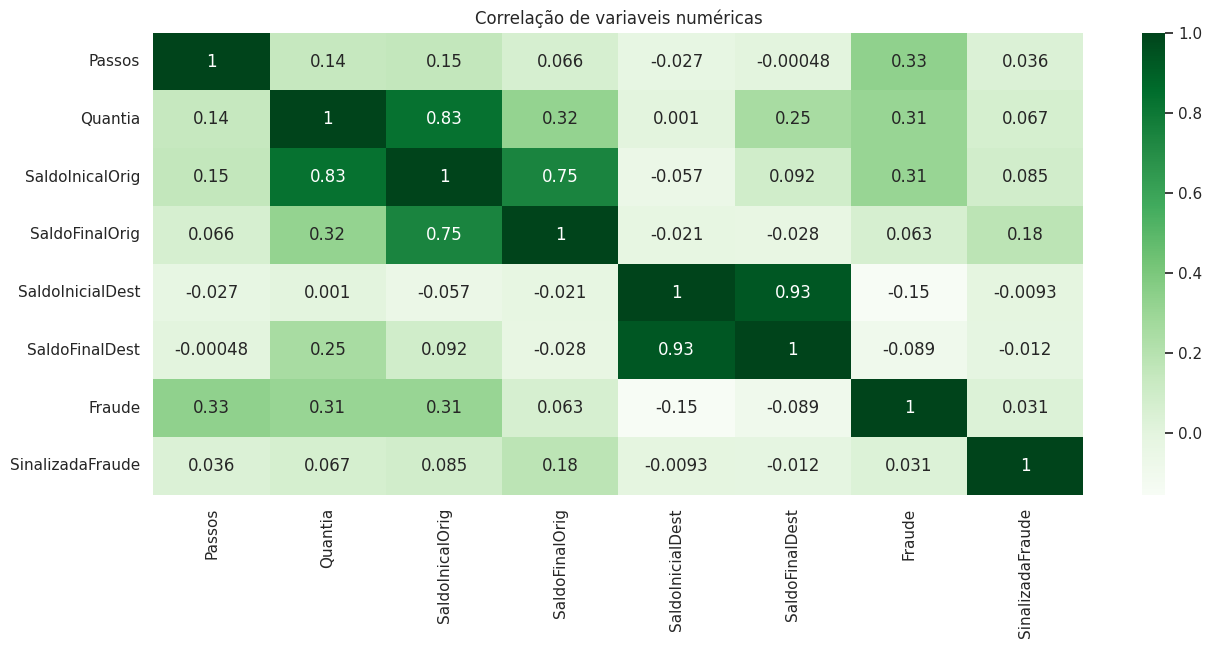

In [58]:
numerico = amostra_uniforme.select_dtypes(include=['int64', 'float64'])

plt.figure(figsize=(15, 6))
sns.heatmap(numerico.corr(method='pearson'), annot=True, cmap='Greens')
plt.title('Correlação de variaveis numéricas');

* Existe uma forte correlação entre Saldo Inicial do Destino e Saldo Final do destino.
* Exite também uma correlação negativa entre Saldo Final Cliente e Saldo Inicial do destino

## 5 - PREPARAÇÃO DOS DADOS

In [59]:
amostra_uniforme_raw2 = amostra_uniforme.copy()
amostra_uniforme_raw2.to_csv(HOME_PATH+INTERIM_DATA_PATH+'base_fraude_raw4.csv')
amostra_uniforme_raw2 = pd.read_csv(HOME_PATH+INTERIM_DATA_PATH+'base_fraude_raw4.csv')

In [60]:
del amostra_uniforme_raw2['Unnamed: 0']
amostra_uniforme_raw2.dtypes

Passos                int64
Tipo                 object
Quantia             float64
ClienteOrigem        object
SaldoInicalOrig     float64
SaldoFinalOrig      float64
ClienteDest          object
SaldoInicialDest    float64
SaldoFinalDest      float64
Fraude                int64
SinalizadaFraude      int64
maior_50%            object
poder_compra         object
tipo_transacao       object
dtype: object

#### VERIFICAR OS OUTILIERS DAS VARIÁVEIS NUMÉRICAS

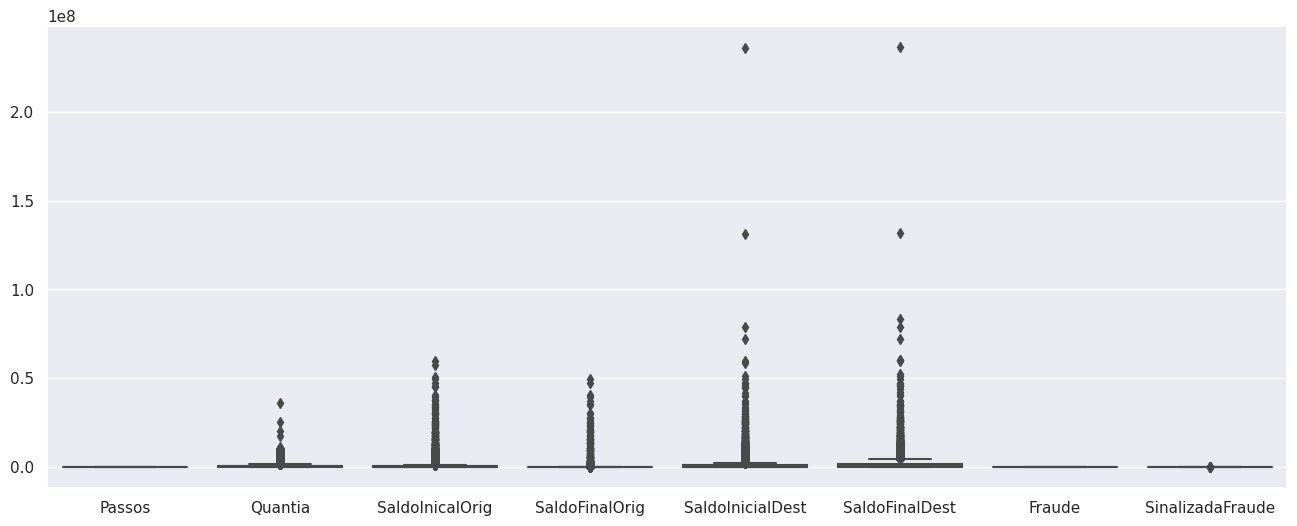

In [61]:
# Gerando um BoxPlot de todas variaveis
plt.figure(figsize=(16,6))
ax = sns.boxplot(data = amostra_uniforme_raw2)

In [62]:
amostra_uniforme_raw2.describe()

,Passos,Quantia,SaldoInicalOrig,SaldoFinalOrig,SaldoInicialDest,SaldoFinalDest,Fraude,SinalizadaFraude
count,16000.00,16000.00,16000.00,16000.00,16000.00,16000.00,16000.00,16000.00
mean,303.92,890172.26,847502.56,103326.06,1115528.94,1654109.67,0.50,0.00
std,193.36,1889386.48,2629824.30,1386050.62,3658738.32,4084915.63,0.50,0.03
min,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,160.00,99443.71,165.00,0.00,0.00,0.00,0.00,0.00
50%,282.00,231802.83,65761.13,0.00,140961.89,486205.90,0.50,0.00
75%,406.00,638676.33,470956.59,0.00,927240.44,1660054.45,1.00,0.00
max,743.00,35819853.11,59585040.37,49585040.37,236230516.82,236726494.66,1.00,1.00


In [63]:
amostra_uniforme_raw2.columns

Index(['Passos', 'Tipo', 'Quantia', 'ClienteOrigem', 'SaldoInicalOrig',
       'SaldoFinalOrig', 'ClienteDest', 'SaldoInicialDest', 'SaldoFinalDest',
       'Fraude', 'SinalizadaFraude', 'maior_50%', 'poder_compra',
       'tipo_transacao'],
      dtype='object')

#### 5.1 - NORMALIZAÇÃO

Normalização:

A normalização é um processo de transformação dos valores de uma variável para uma escala entre 0 e 1. Esse método é útil quando as variáveis têm escalas diferentes e você deseja colocá-las em uma mesma faixa. Isso é especialmente importante para algoritmos que são sensíveis à escala dos dados, como algoritmos de gradiente descendente.

Use a normalização quando:

<ol><li>As variáveis têm escalas diferentes.</li>
<li>Deseja-se restringir os valores das variáveis para uma faixa entre 0 e 1.</li>
<li>Desvio Padrão BAIXO</li>
<li>Normalização não se adapta muito bem com variáveis com muito outilers</li></ol>

<blockquote>MESMO IDENTIFICANDO AS VARIÁVEIS NUMÉRICAS COM ESCALAS DIFERENTES, VERIFICAMOS DESVIO PADRÃO ALTO E OUTILIERS TAMBÉM MUITO ALTOS, PERCEBEMOS UM RANGE (DISTÂNCIA ENTRE O MIN E MAX) MUITO GRANDE. </blockquote>
<blockquote>---------------------------------------------------------------------------------------------</blockquote>

<blockquote>CONCLUÍMOS QUE O MÉTODO DE NORMALIZAÇÃO É IMPROPRIO PARA APLICAR NA NOSSA BASE</blockquote>

<blockquote>---------------------------------------------------------------------------------------------</blockquote>

#### 5.2 - PADRONIZAÇÃO

Padronização:

A padronização é um processo de transformação dos valores de uma variável de forma que ela tenha média zero e desvio padrão igual a 1. 

Esse método é útil quando as variáveis têm diferentes escalas e distribuições, e você deseja transformá-las em uma distribuição normal padrão (média 0 e desvio padrão 1).

Use a padronização quando:

<ol><li>As variáveis têm diferentes escalas e distribuições.</li>
<li>O algoritmo de machine learning utilizado se beneficia de ter as variáveis em uma distribuição normal padrão.</li>
<li>A Padronização é ideal para variáveis de Desvio Padrão muito altos</li>
<li>Padronização se adapta muito bem com variáveis com muitos outilers</li></ol>

Nesse nosso Dataset, verificando as melhores condições para utilizar a Padronização, concluímos que:


<blockquote>PERCEBEMOS CLARAMENTE QUE NOSSO DATASET SE ENQUADRA NAS CARACTERÍSTICAS QUE O MÉTODO SUPORTA.</blockquote>

<blockquote>---------------------------------------------------------------------------------------------</blockquote>

<blockquote>ENTÃO UTILIZAREMOS A PADRONIZAÇÃO COMO MÉTODO MAIS EFICAZ PARA ESCALONAMENTO DAS NOSSAS VARIÁVEIS</blockquote>


<blockquote>---------------------------------------------------------------------------------------------</blockquote>



#### REALIZANDO A PADRONIZAÇÃO DOS DADOS NUMÉRICOS

In [64]:
scaler = RobustScaler()
num_cols = ['Passos', 'Quantia', 'SaldoInicalOrig', 'SaldoFinalOrig', 'SaldoInicialDest', 'SaldoFinalDest']
amostra_uniforme_raw2[num_cols] = scaler.fit_transform(amostra_uniforme_raw2[num_cols])



In [65]:
amostra_uniforme_raw2.head()

,Passos,Tipo,Quantia,ClienteOrigem,SaldoInicalOrig,SaldoFinalOrig,ClienteDest,SaldoInicialDest,SaldoFinalDest,Fraude,SinalizadaFraude,maior_50%,poder_compra,tipo_transacao
0,0.30,CASH_OUT,-0.42,C1207936340,-0.08,26668.31,C23530886,2.31,1.08,0,0,no,alta,C para C
1,-0.13,CASH_OUT,0.04,C125604385,-0.14,0.00,C49539194,0.19,0.05,0,0,yes,baixa,C para C
2,0.36,CASH_OUT,0.11,C597676579,-0.11,0.00,C395456933,0.40,0.19,0,0,yes,medio,C para C
3,-0.61,TRANSFER,-0.29,C835612655,-0.14,0.00,C1552605489,1.33,0.58,0,0,yes,baixa,C para C
4,0.48,CASH_OUT,-0.32,C1955581948,-0.07,0.00,C746965294,0.85,0.30,0,0,no,alta,C para C


#### 5.3 - TRANSFORMAÇÃO

In [66]:
# Realizando LabelEncoding para 'poder_compra' e 'maior_50'
label_encoder = LabelEncoder()
amostra_uniforme_raw2['poder_compra'] = label_encoder.fit_transform(amostra_uniforme_raw2['poder_compra'])
amostra_uniforme_raw2['maior_50%'] = label_encoder.fit_transform(amostra_uniforme_raw2['maior_50%'])
amostra_uniforme_raw2['Tipo'] = label_encoder.fit_transform(amostra_uniforme_raw2['Tipo'])
amostra_uniforme_raw2['tipo_transacao'] = label_encoder.fit_transform(amostra_uniforme_raw2['tipo_transacao'])

# type
#amostra_uniforme_raw2 = pd.get_dummies(amostra_uniforme_raw2, prefix='Tipo', columns=['Tipo'])

# type_transaction
"""amostra_uniforme_raw2 = pd.get_dummies(amostra_uniforme_raw2, prefix='tipo_transacao', columns=['tipo_transacao'])"""


"amostra_uniforme_raw2 = pd.get_dummies(amostra_uniforme_raw2, prefix='tipo_transacao', columns=['tipo_transacao'])"

In [6]:
amostra_uniforme_raw2.head()

NameError: name 'amostra_uniforme_raw2' is not defined

##### 5.3.1 - VARIAVEIS DEPEDENTES


##### 5.3.2 - VARIAVEL RESPOSTA

## 6 - SELEÇÃO DE FEATURES

### 6.1 - ESCOLHENDO AS VARIAVEIS RELEVANTES

In [6]:
"""amostra_uniforme_raw3 = amostra_uniforme_raw2.copy()
amostra_uniforme_raw3.to_csv(HOME_PATH+INTERIM_DATA_PATH+'base_fraude_raw4.csv')"""
amostra_uniforme_raw3 = pd.read_csv(HOME_PATH+INTERIM_DATA_PATH+'base_fraude_raw4.csv')

In [7]:
del amostra_uniforme_raw3['Unnamed: 0']
amostra_uniforme_raw3.columns

Index(['Passos', 'Tipo', 'Quantia', 'ClienteOrigem', 'SaldoInicalOrig',
       'SaldoFinalOrig', 'ClienteDest', 'SaldoInicialDest', 'SaldoFinalDest',
       'Fraude', 'SinalizadaFraude', 'maior_50%', 'poder_compra',
       'tipo_transacao'],
      dtype='object')

### 6.2 - DIVISÃO TREINO, VALIDAÇÃO E TESTE

In [8]:
"""# Dividir a base de dados em treino, validação e teste usando amostragem estratificada
X = amostra_uniforme_raw3.drop(['Fraude', 'ClienteOrigem', 'ClienteDest'], axis=1)  # Variáveis preditoras
y = amostra_uniforme_raw3['Fraude']  # Variável alvo

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, stratify=y_train, random_state=42)"""

# Divide em conjunto de treino (70%), validação (15%) e teste (15%)
X_train_val, X_test, y_train_val, y_test = train_test_split(amostra_uniforme_raw3.drop(['Fraude', 'ClienteOrigem', 'ClienteDest'], axis=1), amostra_uniforme_raw3['Fraude'], test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.1764, random_state=42)

In [9]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(11200, 11)
(2400, 11)
(2400, 11)


In [10]:
X_train

,Passos,Tipo,Quantia,SaldoInicalOrig,SaldoFinalOrig,SaldoInicialDest,SaldoFinalDest,SinalizadaFraude,maior_50%,poder_compra,tipo_transacao
15357,-1.04,0,0.49,0.91,0.00,0.35,0.29,0,0,0,0
15362,0.74,1,1.74,2.34,0.00,-0.15,-0.29,0,0,0,0
3794,-1.09,0,0.45,-0.08,0.00,0.13,0.15,0,1,0,0
3046,-0.50,0,-0.22,-0.13,0.00,1.94,0.94,0,1,2,0
15927,0.36,0,-0.05,0.30,0.00,-0.15,-0.17,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
540,0.08,0,0.12,-0.14,0.00,-0.15,-0.11,0,1,1,0
1028,-0.28,0,-0.17,-0.14,0.00,1.98,0.98,0,1,1,0
6697,-0.62,0,-0.04,-0.14,0.00,0.08,-0.03,0,1,1,0
12143,-1.09,1,7.03,8.40,0.00,-0.15,-0.29,0,0,0,0


## 7.0 - MODELAR ALGORITIMOS DE MACHINE LEARNING

In [11]:
"""amostra_uniforme_raw4 = amostra_uniforme_raw3.copy()
amostra_uniforme_raw4.to_csv(HOME_PATH+INTERIM_DATA_PATH+'base_fraude_raw4.csv')"""
amostra_uniforme_raw4 = pd.read_csv(HOME_PATH+INTERIM_DATA_PATH+'base_fraude_raw4.csv')

In [12]:
X_train

,Passos,Tipo,Quantia,SaldoInicalOrig,SaldoFinalOrig,SaldoInicialDest,SaldoFinalDest,SinalizadaFraude,maior_50%,poder_compra,tipo_transacao
15357,-1.04,0,0.49,0.91,0.00,0.35,0.29,0,0,0,0
15362,0.74,1,1.74,2.34,0.00,-0.15,-0.29,0,0,0,0
3794,-1.09,0,0.45,-0.08,0.00,0.13,0.15,0,1,0,0
3046,-0.50,0,-0.22,-0.13,0.00,1.94,0.94,0,1,2,0
15927,0.36,0,-0.05,0.30,0.00,-0.15,-0.17,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
540,0.08,0,0.12,-0.14,0.00,-0.15,-0.11,0,1,1,0
1028,-0.28,0,-0.17,-0.14,0.00,1.98,0.98,0,1,1,0
6697,-0.62,0,-0.04,-0.14,0.00,0.08,-0.03,0,1,1,0
12143,-1.09,1,7.03,8.40,0.00,-0.15,-0.29,0,0,0,0


### 7.1 - MODELO DE REFERNCIA

### 7.2 - MODELO LINEAR

,Model_name,Balanced_accuracy,Precision,Recall,F1-score
0,Logistic Regression,0.81,0.83,0.78,0.81


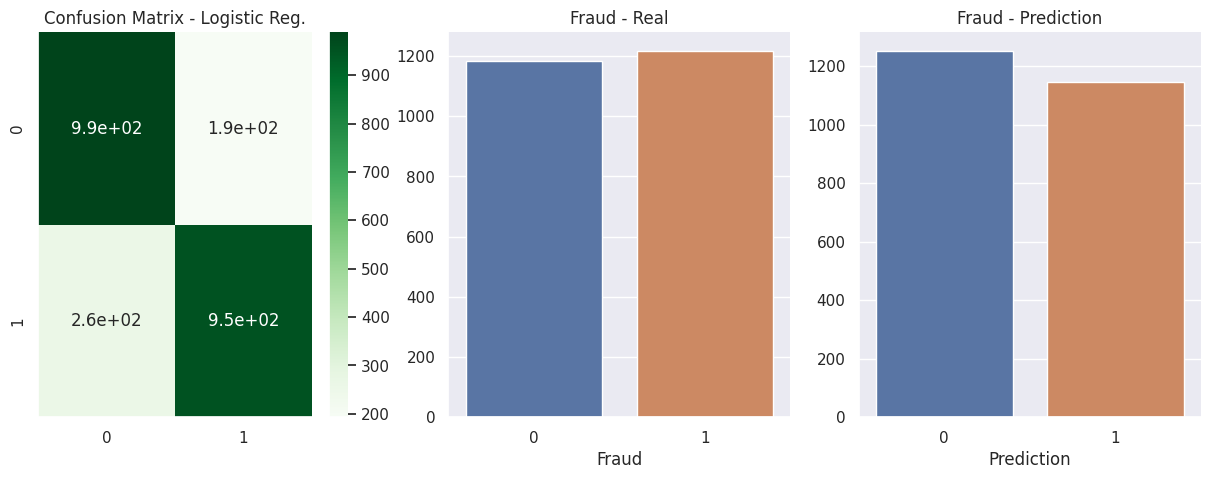

In [17]:
# define Logistic Regression
lr = LogisticRegression()

# model training
lr_trained = lr.fit(X_train, y_train)

# predict with validation
previsoes = lr_trained.predict(X_val)

# compute metric
metrics_lr = compute_metrics(model_name='Logistic Regression', y_validation=y_val, yhat=previsoes)

# show graph
plot_metric(y_val, previsoes, 'Logistic Reg.')

# show metric
metrics_lr



In [14]:
print(classification_report(y_val, previsoes))

              precision    recall  f1-score   support

           0       0.79      0.84      0.81      1182
           1       0.83      0.78      0.81      1218

    accuracy                           0.81      2400
   macro avg       0.81      0.81      0.81      2400
weighted avg       0.81      0.81      0.81      2400



In [ ]:
resultados_logistica = []

for i in range(30):
    print(i)
    kfold = KFold(n_splits=10, shuffle=True, random_state=i)

    logistica = LogisticRegression()
    scores = cross_val_score(logistica, X_train, y_train, cv= kfold)
    resultados_logistica.append(scores.mean())

In [19]:
resultados = pd.DataFrame({'Logistica':resultados_logistica})
resultados

,Logistica
0,0.82
1,0.82
2,0.82
3,0.82
4,0.83
5,0.82
6,0.82
7,0.82
8,0.82
9,0.82


In [20]:
resultados.describe()

,Logistica
count,30.00
mean,0.82
std,0.00
min,0.82
25%,0.82
50%,0.82
75%,0.82
max,0.83


In [22]:
(resultados.std() / resultados.mean()) * 100

Logistica   0.27
dtype: float64

### 7.3 - MODELO NÃO LENEAR

#### 7.4.1 - DESEMPENHO INDIVUDUAL

#### 7.4.2 - DESEMPEHHO REAL

## 8.0 - AJUSTE DE HIPERPARAMETROS

### 8.1 - BUSCA ALEATORIO OU RANDOM SEARCH

### 8.2 - MODELO FINAL

## - 9.0 - TRADUÇÃO E INTERPRETAÇÃO DO ERRO

### 9.1 - DESEMPENHO DO NEGÓCIO

### 9.2 - DESEMPENHO TOTAL

### 9.3 - DESEMOENHO DO MODELO DE MACHINE LEARNING

## 10 - DEPLOY